## Director Analysis

This section of the notebook looks at different directors in the credits dataset. It looks at the number of films each director has made and presents analysis on the top ten most prolific movie directors. To do this analysis it parses the names of the directors and their movies. It also merges the budget and revenue information from the movies_metadata dataset with the director information.

In [180]:
%matplotlib inline

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

In [181]:
# Read in the dataset to a pandas dataframe
metadata = pd.read_csv('../cogs108_data/movies_metadata.csv')
credits = pd.read_csv('../cogs108_data/credits.csv')

/home/madeleine/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [182]:
# Remove cast column in credits
credits = credits.drop('cast', axis=1)

In [183]:
# This function takes a string element from the crew column and returns the
# name of the director
def getDirector(row):
    start = row.find("\'Director\'")
    nameBegin = row[start:len(row)].find("\'name\': \'")
    number = len("\'name\': \'")
    nameEnd = row[start+nameBegin + number:len(row)].find("\'")
    name = row[start+nameBegin + number:start+nameBegin + number + nameEnd]
    if len(name) == 0:
        return '0'
    return name
    

In [184]:
# Function parses the gender of the director
def getDirectorGender(row):
    end = row.find('Director')
    start = row[0:end].rfind('\'gender\': ')
    gender = row[start + len('\'gender\': '): start + len('\'gender\': ') + 1]
    if len(gender) == 0:
        return -1
    return gender
    

In [185]:
# Creating new columns from the parsed data
credits['director'] = credits['crew'].apply(getDirector)
credits['gender'] = credits['crew'].apply(getDirectorGender)

In [186]:
# Removing rows that have missing or unknown gender
credits = credits[credits['gender'] != -1]
credits = credits[credits['gender'] != '0']
# Removing rows that have missing director
credits = credits[credits['director'] != 'it_id']

In [187]:
# Dropping the now unnecessary crew column
credits = credits.drop('crew', axis=1)

In [188]:
# Numbers of each gender in the dataset
numFdirectors = sum(credits['gender'] == '1')
numMdirectors = sum(credits['gender'] == '2')

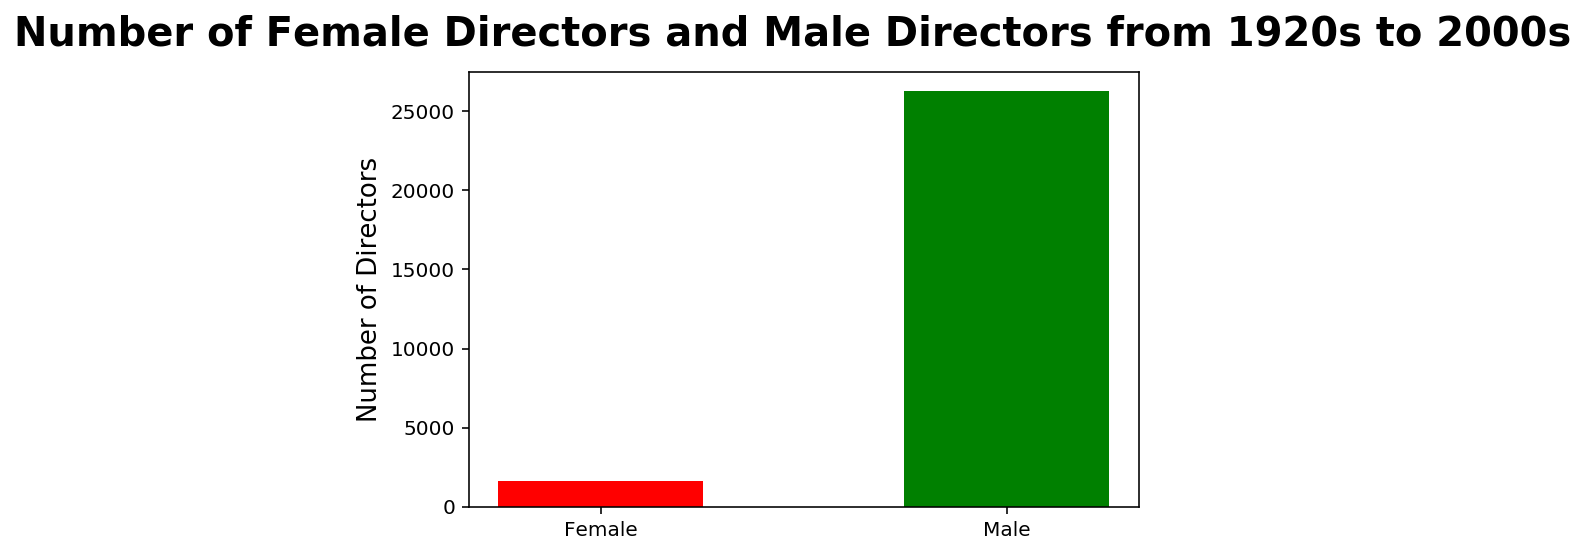

In [189]:
y = [numFdirectors, numMdirectors]
N = len(y)
x = range(N)
width = 0.5
barlist = plt.bar(x, y, width)
plt.suptitle('Number of Female Directors and Male Directors from 1920s to 2000s', fontsize=20, fontweight='bold')
plt.ylabel('Number of Directors', fontsize=13)
barlist[0].set_color('r')
barlist[1].set_color('g')
plt.xticks(x, ['Female', 'Male'])
plt.show()

This graph shows the ratio of female directors to male directors in the movie world. 

In [190]:
# Grabbing the ten directors who have made the most movies
director_frequency = credits['director'].value_counts()[0:10]

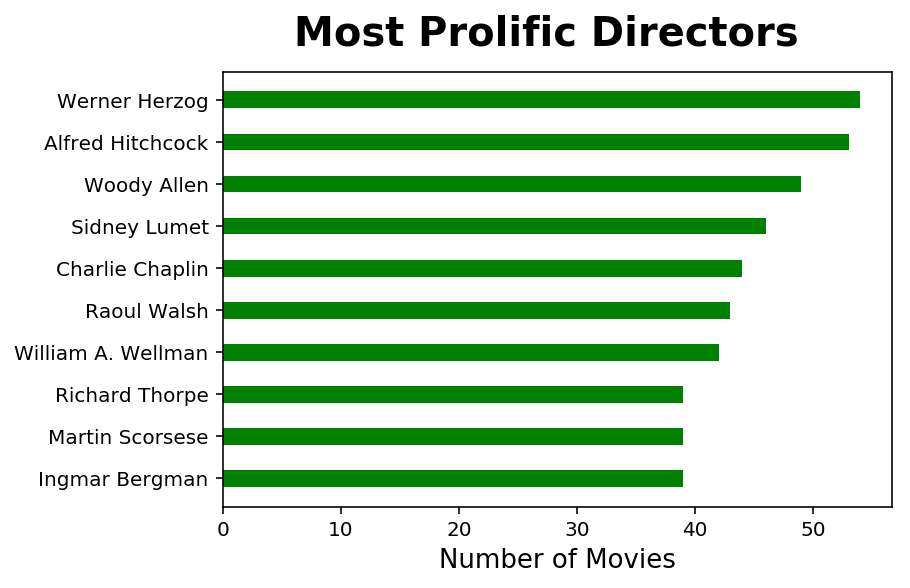

In [191]:
list_of_directors = director_frequency.index.tolist()[::-1]
y = director_frequency.tolist()[::-1]
N = len(y)
x = range(N)
width = 0.4
barlist = plt.barh(x, y, width, color='g')
plt.suptitle('Most Prolific Directors', fontsize=20, fontweight='bold')
plt.xlabel('Number of Movies', fontsize=13)
plt.yticks(x, list_of_directors)
plt.show()

This graph shows the ten directors who have made the highest number of films. If you notice however, there are no women on this list. The next graph shows the most prolific female directors for comparison.

In [192]:
# Grabbing the ten female directors who have made the most movies
female_directors = credits[credits['gender'] == '1']
directorF_frequency = female_directors['director'].value_counts()[0:10]

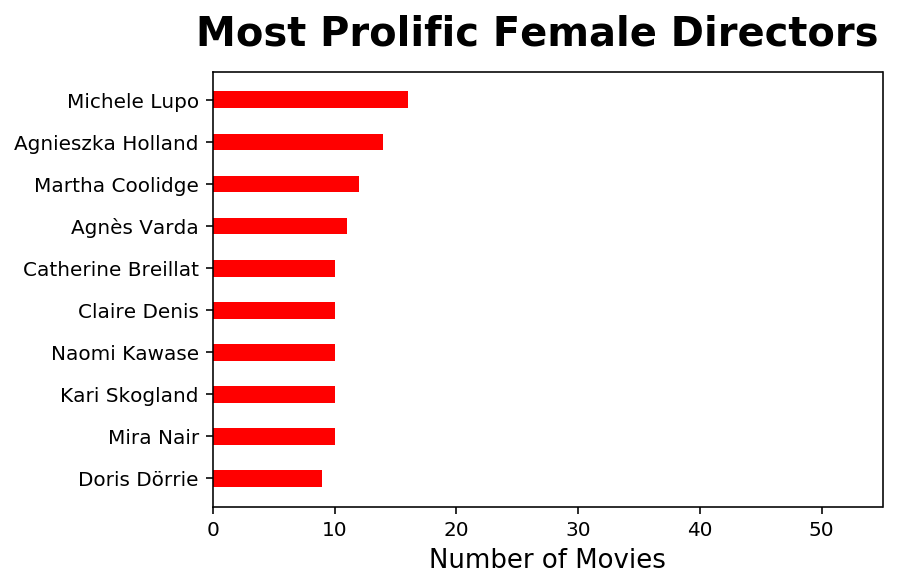

In [193]:
list_of_directorsF = directorF_frequency.index.tolist()[::-1]
y = directorF_frequency.tolist()[::-1]
N = len(y)
x = range(N)
width = 0.4
barlist = plt.barh(x, y, width, color='r')
plt.suptitle('Most Prolific Female Directors', fontsize=20, fontweight='bold')
plt.xlim([0, 55])
plt.xlabel('Number of Movies', fontsize=13)
plt.yticks(x, list_of_directorsF)
plt.show()

This graph shows the most prolific female directors. Amusingly(or not), the woman with the highest number of films is Michele Lupo. Lupo is actually a man; he was coded wrong in the dataset because his name is usually considered a woman's name in the U.S. You might notice that many of the names on this list do not look western. There are only two Americans on this list, Mira Nair and Martha Coolidge. This suggests that other countries have done a better job of supporting women in leadership roles in the moviemaking industry. In particular, half of these women are French.  I would like to do further research on why France has so many female filmmakers but that is for another project. I did find an article on this subject which can be seen here: https://www.theguardian.com/film/2011/mar/24/france-women-directors

## Budget Analysis

This upcoming analysis pulls in budget and revenue information. This information is not available for every movie in our dataset so we were only able to analyze ten percent of our original data. This means that the ten most prolific directors change from the previous analysis. It also skews our data toward western directors as the dataset is more likely to have budget information on western films.

In [194]:
# Keeping only the relevent columns in movie_metadata dataset
new_metadata = metadata[['budget', 'revenue', 'id']]

In [195]:
# Clean movies_metadata Dataframe
new_metadata['id'] = new_metadata['id'].apply(pd.to_numeric, errors='coerce')
new_metadata = new_metadata[np.isfinite(new_metadata['id'])]

/home/madeleine/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [196]:
# Merge two datasets
direct_df = new_metadata.merge(credits, on='id')

In [197]:
# Turn budget column into numeric data
direct_df['budget'] = direct_df['budget'].apply(pd.to_numeric)

In [198]:
# Replace all 0 values with nan
direct_df['budget'].replace(0, np.nan, inplace=True)
direct_df['revenue'].replace(0, np.nan, inplace=True)

In [199]:
# Drop all nan values
direct_df = direct_df.dropna()

In [200]:
# Gets average budget for the 10 most prolific directors
mean_budget = list()

director_frequency = direct_df['director'].value_counts()[0:10]
director_frequency = director_frequency.index.tolist()

def get_mean_budget(director):
    return np.mean(direct_df[direct_df['director'] == director]['budget'])

for i in director_frequency:
    mean_budget.append(get_mean_budget(i))


In [201]:
# Sort mean budget
zipped = zip(director_frequency, mean_budget)
sorted_zipped = sorted(zipped, key=lambda x: x[1])
director_frequency, mean_budget = zip(*sorted_zipped)

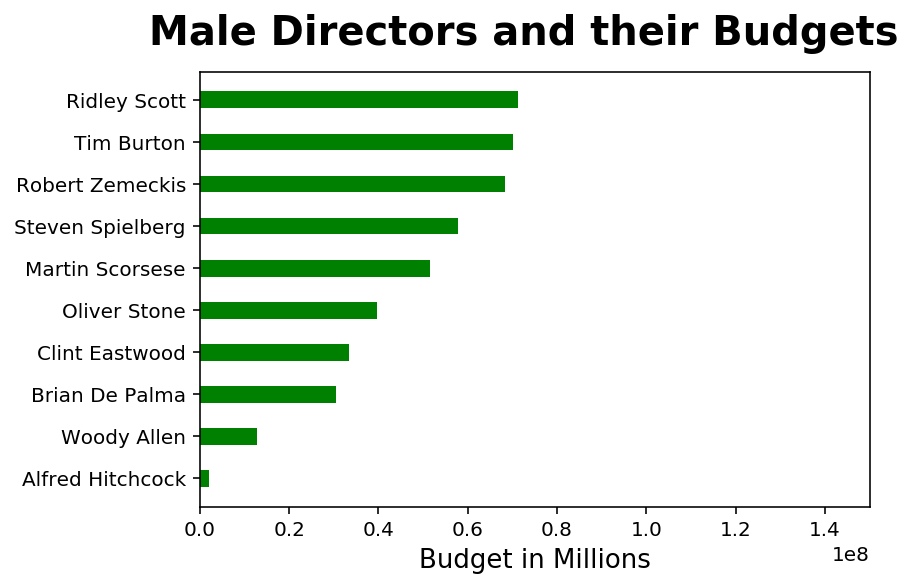

In [202]:
y = mean_budget
N = len(y)
x = range(N)
width = 0.4
barlist = plt.barh(x, y, width, color='g')
plt.suptitle('Male Directors and their Budgets', fontsize=20, fontweight='bold')
plt.xlabel('Budget in Millions', fontsize=13)
plt.yticks(x, director_frequency)
plt.xlim([0, 1.5e8])
plt.show()

This graph shows the top 10 most prolific directors and the average budget they worked with on a movie. It is sorted by average budget. Again, all of these directors are men, so the next graph looks at female directors for comparison.

In [203]:
female_directors = direct_df[direct_df['gender'] == '1']
mean_budget_female = list()

directorF_frequency = female_directors['director'].value_counts()[0:10]
directorF_frequency = directorF_frequency.index.tolist()

for i in directorF_frequency:
    mean_budget_female.append(get_mean_budget(i))
    

In [204]:
# Sort mean_budget
zipped = zip(directorF_frequency, mean_budget_female)
sorted_zipped = sorted(zipped, key=lambda x: x[1])
directorF_frequency, mean_budget_female = zip(*sorted_zipped)

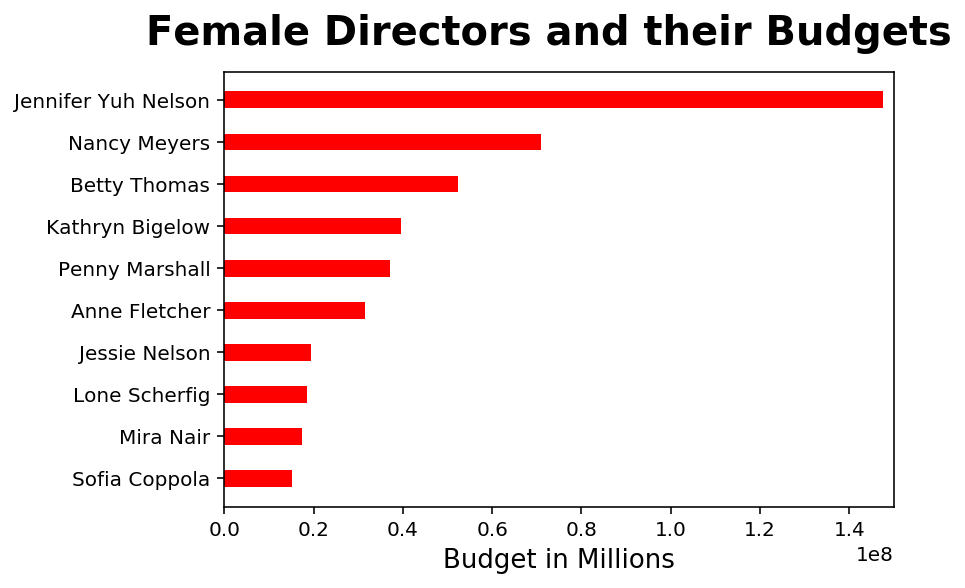

In [205]:
y = mean_budget_female
N = len(y)
x = range(N)
width = 0.4
barlist = plt.barh(x, y, width, color='r')
plt.suptitle('Female Directors and their Budgets', fontsize=20, fontweight='bold')
plt.xlabel('Budget in Millions', fontsize=13)
plt.yticks(x, directorF_frequency)
plt.xlim([0, 1.5e8])
plt.show()

This graph shows the average budget that the ten most prolific female directors worked with. It is smaller than the male directors. Budget and revenue comparison are difficult with respect to gender; there is much more data on men than on women. For example, Jennifer Yuh Nelson has the highest average budget out of the directors. The reason why it looks like she has a huge average budget is that she directed Kung Fu Panda 2, a movie which made her the first women to solely direct an animated Hollywood movie. In the database she has only directed two movies which is another reason why her average budget is so high.

Information about Jennifer Yuh Nelson was snagged from https://en.wikipedia.org/wiki/Jennifer_Yuh_Nelson. 

## Revenue Analysis

The next analysis will be looking at how much money films make tied to the top ten most prolific directors. It will be analyzing net profit with respect to gender.

In [161]:
# Getting the mean revenue for female directors
gross_earnings_f = list()

def get_mean_revenue(director):
    return np.mean(direct_df[direct_df['director'] == director]['revenue'] - direct_df[direct_df['director'] == director]['budget'])

for i in directorF_frequency:
    gross_earnings_f.append(get_mean_revenue(i))

In [162]:
# Sort mean revenue
zipped = zip(directorF_frequency, gross_earnings_f)
sorted_zipped = sorted(zipped, key=lambda x: x[1])
directorF_frequency, gross_earnings_f = zip(*sorted_zipped)

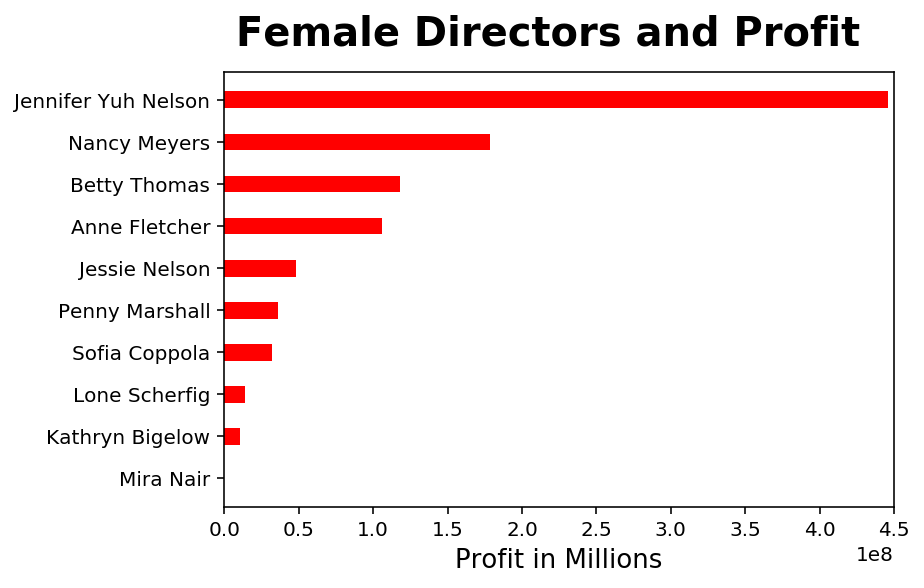

In [177]:
y = gross_earnings_f
N = len(y)
x = range(N)
width = 0.4
barlist = plt.barh(x, y, width, color='r')
plt.suptitle('Female Directors and Profit', fontsize=20, fontweight='bold')
plt.xlabel('Profit in Millions', fontsize=13)
plt.yticks(x, directorF_frequency)
plt.xlim([0, 4.5e8])
plt.show()

This graph shows the average net profit for the ten most prolific female directors. Again, Jennifer Yuh Nelson is tied to the highest average profit. For comparison, the next graph will show the highest average profit for male directors.

In [165]:
# Net profit for male directors
gross_earnings_m = list()

for i in director_frequency:
    gross_earnings_m.append(get_mean_revenue(i))

In [166]:
# Sort mean revenue
zipped = zip(director_frequency, gross_earnings_m)
sorted_zipped = sorted(zipped, key=lambda x: x[1])
director_frequency, gross_earnings_m = zip(*sorted_zipped)

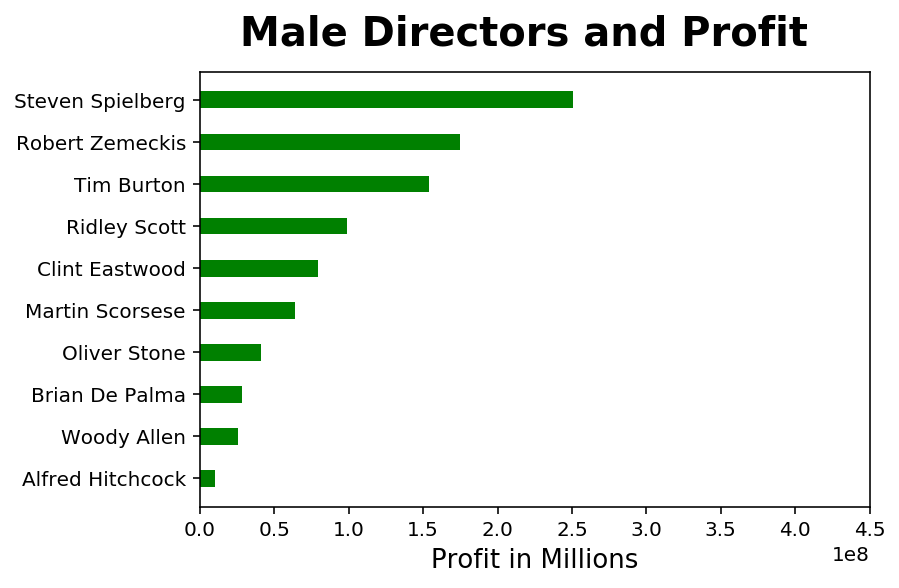

In [176]:
y = gross_earnings_m
N = len(y)
x = range(N)
width = 0.4
barlist = plt.barh(x, y, width, color='g')
plt.suptitle('Male Directors and Profit', fontsize=20, fontweight='bold')
plt.xlabel('Profit in Millions', fontsize=13)
plt.yticks(x, director_frequency)
plt.xlim([0, 4.5e8])
plt.show()

This graph shows the average profit made by the top ten most prolific male directors. It is challenging to compare this graph with the previous graph because there are so few female directors. However these two graphs look similar, with the male directors earning slightly more than the female directors. This could be due to the smaller budgets female directors work with. Most importantly, the difference between these two graphs is much smaller than the previous male/female director comparison graphs. This suggests that female directors make just as much money for film companies as men. 